# 2023-08-30__STA_examples

(Result of workflow speed (& ergonomy) tests: full Julia (no Python hybrid))

So, for all 10 Ns;\
For 10 diff seeds;
for both exc, inh, and unconn;\
we conntest (maximum) 100 input spike trains.\
(Each test is comprised of calculating 101 STAs: one real and the rest with shuffled ISIs).

From the prev nb (https://tfiers.github.io/phd/nb/2023-08-16__STA_conntest_pyjulia.html),
we found we'd take a shorter window, so that 'area over start' measure (to determine if exc or inh) is correct.

But ok, it's good to show that in thesis.\
So, we repeat an example STA plot here.

for full N ofc.

In [2]:
include("lib/Nto1.jl")

using Revise … ✔ (0.3 s)
using Units, Nto1AdEx, ConnectionTests, ConnTestEval … 

[ Info: Precompiling Nto1AdEx [368485ca-63bc-4029-854f-349d2205662c]


✔ (1.5 s)
using StatsBase … ✔ (0.2 s)


In [3]:
N = 6500;

In [4]:
duration = 10minutes

600

In [5]:
@time sim = Nto1AdEx.sim(N, duration);

  2.994944 seconds (2.14 M allocations: 1.027 GiB, 2.34% gc time, 42.14% compilation time)


(1st run: 2.5 secs, 27% compilation time).

We want our input spiketrains sorted: the highest spikers first.\
And split exc/inh, too.

In [7]:
include("lib/df.jl")

using DataFrames … ✔ (0.7 s)


In [8]:
exc_inputs = highest_firing(excitatory_inputs(sim))

tabulate(trains) = DataFrame(
    "# input spikes" => num_spikes.(trains),
    "spike rate (Hz)" => spikerate.(trains)
)
tabulate(exc_inputs)

Row,# input spikes,spike rate (Hz)
,Int64,Float64
1,58522,97.5
2,35312,58.9
3,24428,40.7
4,20653,34.4
5,18898,31.5
⋮,⋮,⋮
5196,194,0.323
5197,185,0.308
5198,175,0.292


In [9]:
inh_inputs = highest_firing(inhibitory_inputs(sim))

tabulate(inh_inputs)

Row,# input spikes,spike rate (Hz)
,Int64,Float64
1,21808,36.3
2,21054,35.1
3,16402,27.3
4,14905,24.8
5,14429,24
⋮,⋮,⋮
1296,234,0.39
1297,220,0.367
1298,218,0.363


( :) )

In [10]:
STA = calc_STA(sim.V, exc_inputs[1].times);

In [11]:
include("lib/plot.jl")

import PythonCall … ✔ (2 s)
import PythonPlot … ✔ (3.7 s)
using Sciplotlib … ✔ (0.5 s)
using PhDPlots … ✔


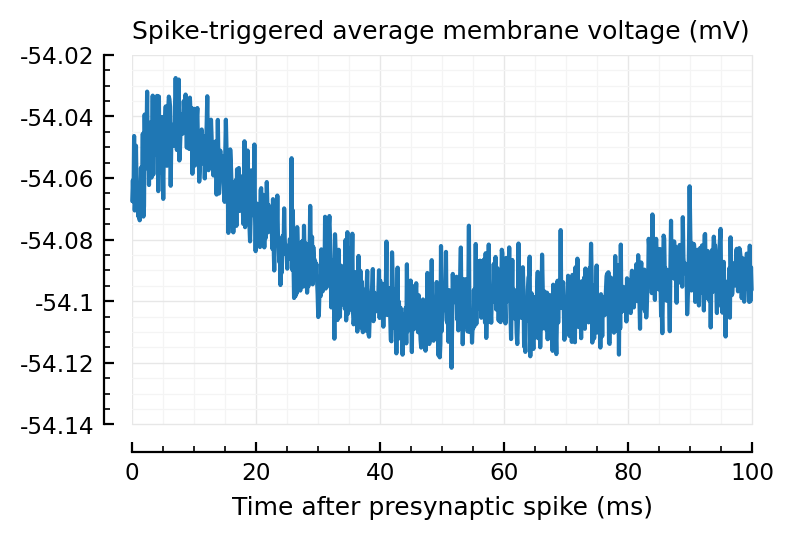

In [12]:
plotSTA(STA);

To compare with predicted PSP height (0.04 mV):

In [13]:
(maximum(STA) - first(STA)) / mV

0.0399

(Woah, that's close)

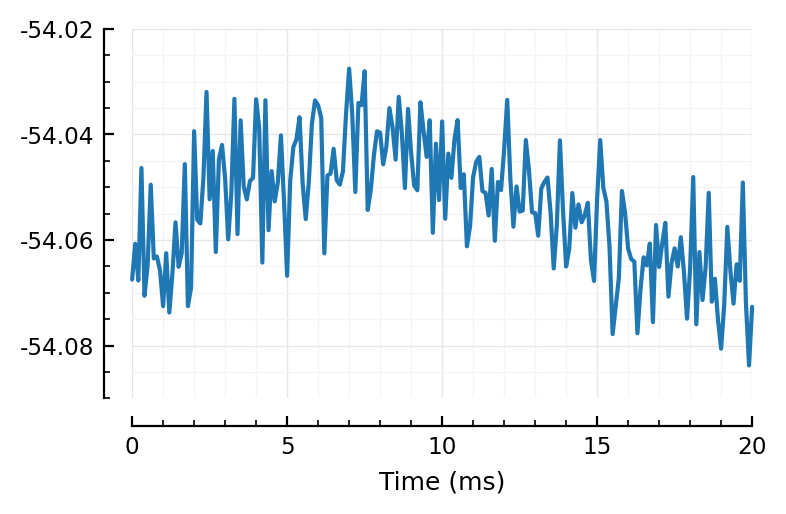

In [14]:
plotsig(STA/mV, [0,20], ms);

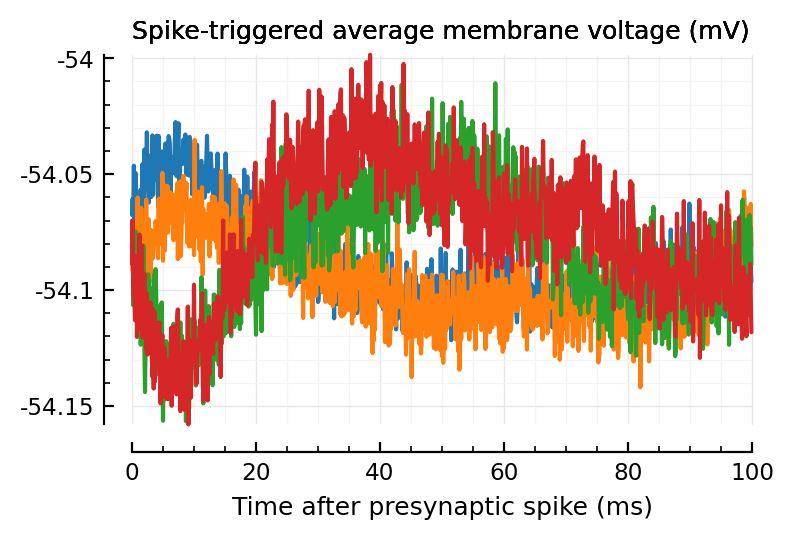

In [15]:
plotSTA_(train, sim=sim; kw...) = begin
    nspikes = num_spikes(train)
    EI = train ∈ exc_inputs ? "exc" : "inh"
    label = "$nspikes spikes, $EI"
    plotSTA(calc_STA(sim.V, train.times); label, kw...)
end
    
plotSTA_(exc_inputs[1]);
plotSTA_(exc_inputs[2]);
plotSTA_(inh_inputs[1]);
plotSTA_(inh_inputs[2]);

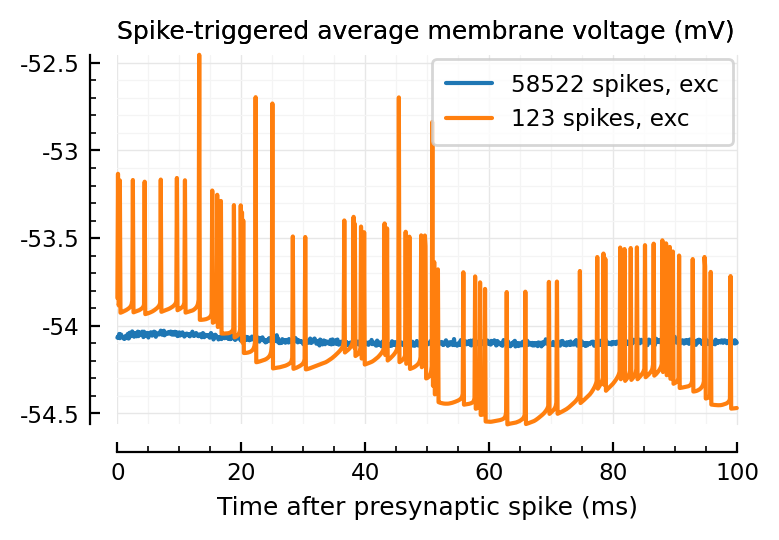

In [16]:
plotSTA_(exc_inputs[1]);
plotSTA_(exc_inputs[end]);
plt.legend();

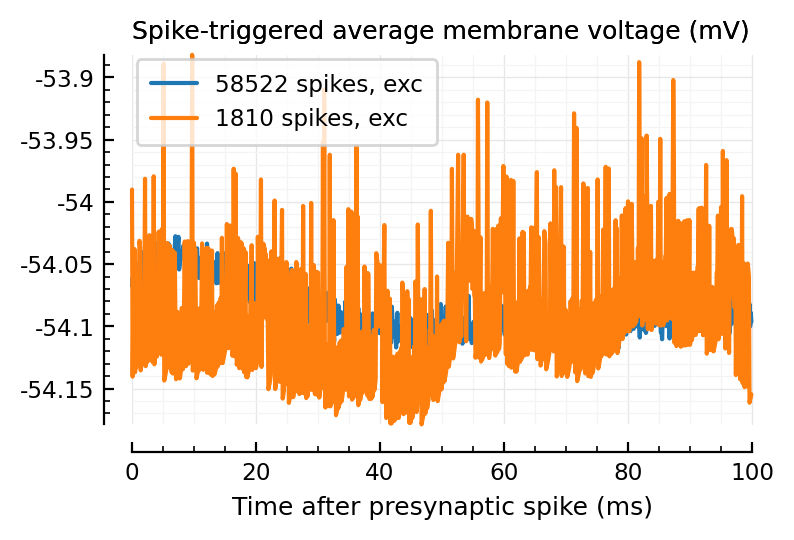

In [17]:
mid = length(exc_inputs) ÷ 2

plotSTA_(exc_inputs[1]);
plotSTA_(exc_inputs[mid]);
plt.legend();

## Four-panel plot

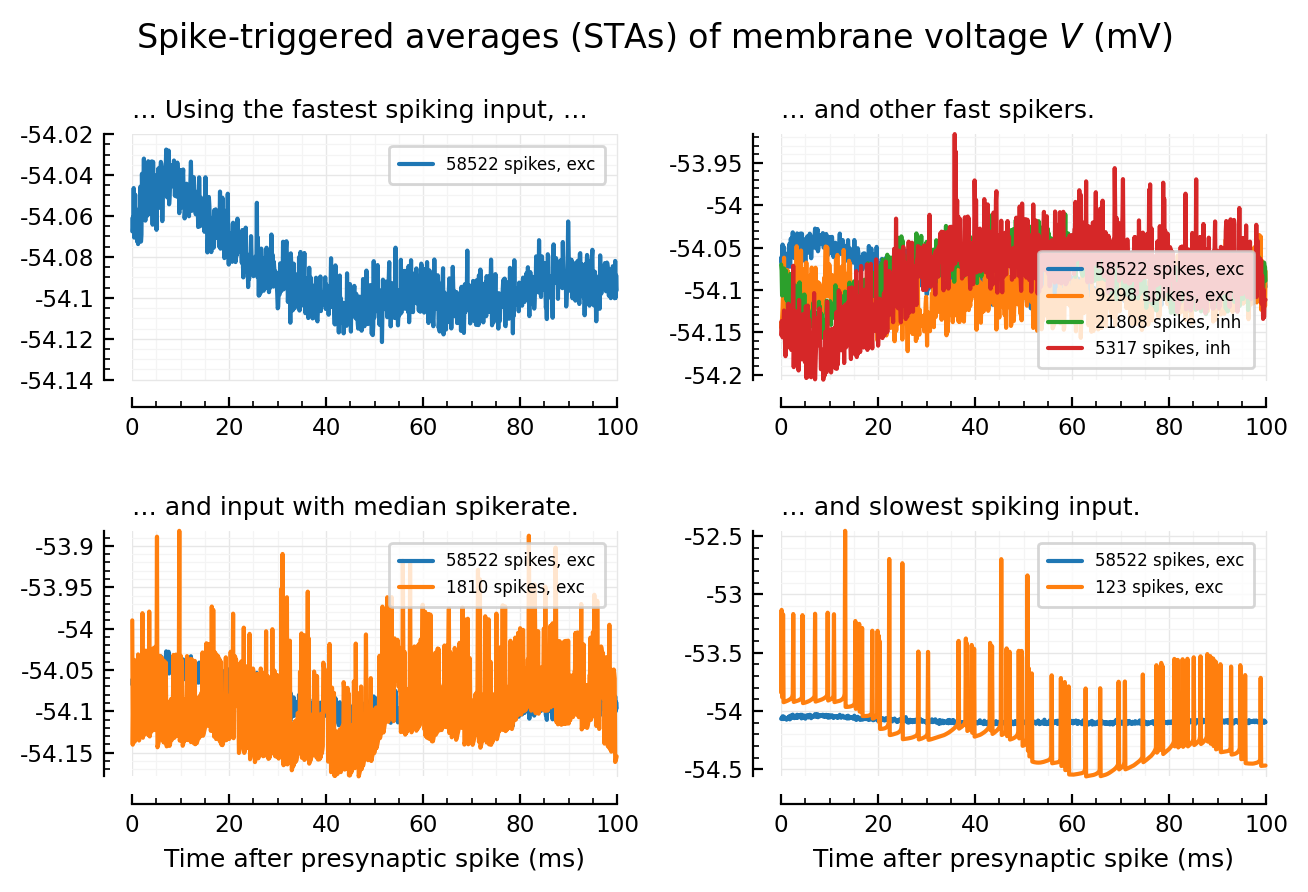

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(pw*0.8, mtw))
plotSTA_2(args...; hylabel=nothing, kw...) = plotSTA_(args...; hylabel, kw...)

addlegend(ax; kw...) = legend(ax, fontsize=6, borderaxespad=0.7; kw...)

plotSTA_2(exc_inputs[1], ax=axs[0,0], hylabel="… Using the fastest spiking input, …", xlabel=nothing);
addlegend(axs[0,0])

plotSTA_2(exc_inputs[1], ax=axs[0,1], hylabel="… and other fast spikers.", xlabel=nothing);
plotSTA_2(exc_inputs[100], ax=axs[0,1], xlabel=nothing)
plotSTA_2(inh_inputs[1], ax=axs[0,1], xlabel=nothing)
plotSTA_2(inh_inputs[100], ax=axs[0,1], xlabel=nothing)
addlegend(axs[0,1], loc="lower right")


plotSTA_2(exc_inputs[1], ax=axs[1,1], hylabel="… and slowest spiking input.");
plotSTA_2(exc_inputs[end], ax=axs[1,1]);
addlegend(axs[1,1])

plotSTA_2(exc_inputs[1], ax=axs[1,0], hylabel="… and input with median spikerate.");
plotSTA_2(exc_inputs[mid], ax=axs[1,0]);
addlegend(axs[1,0], loc="upper right")

plt.suptitle(L"Spike-triggered averages (STAs) of membrane voltage $V$ (mV)")

plt.tight_layout(h_pad=2);

# savefig_phd("example_STAs")

Saved at `../thesis/figs/example_STAs.pdf`

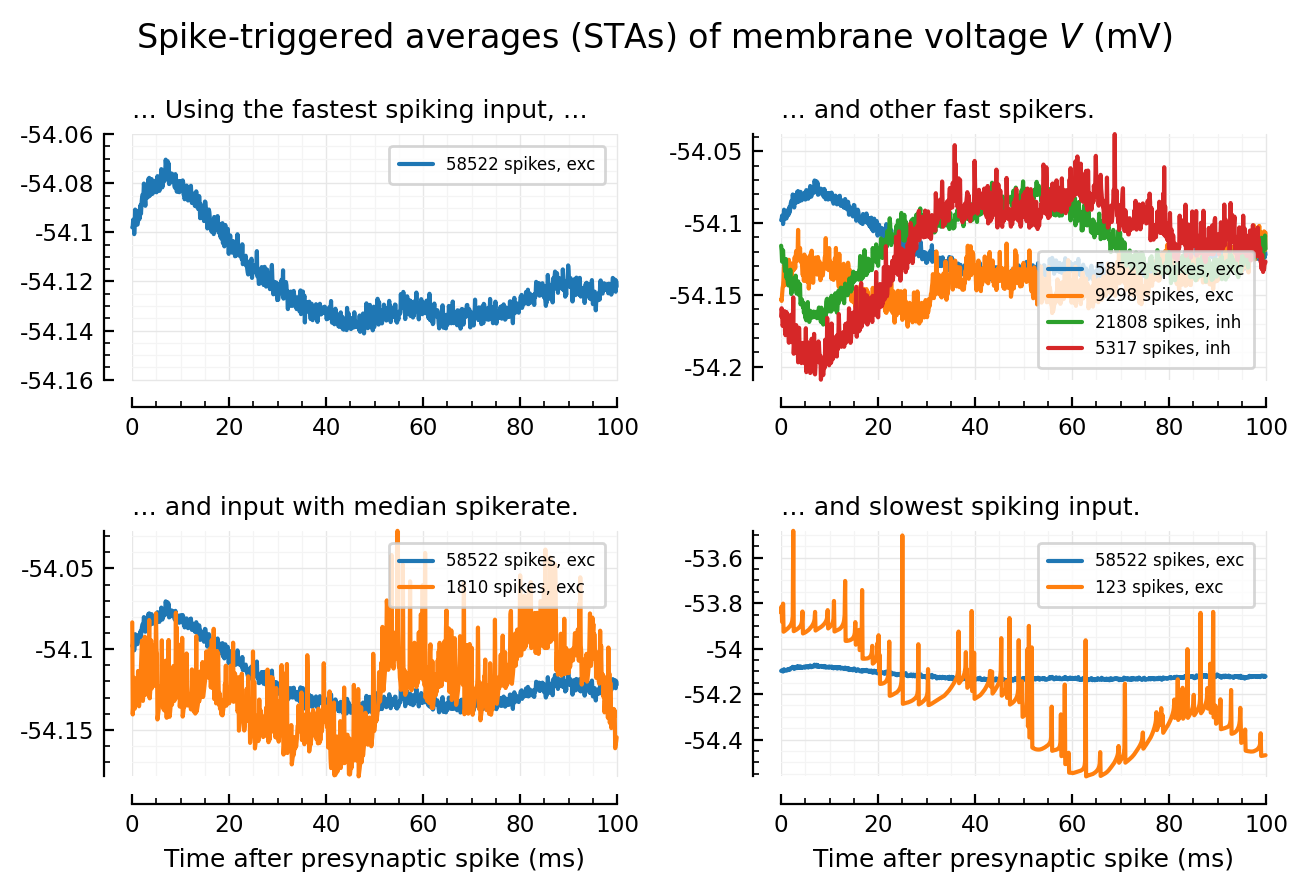

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(pw*0.8, mtw))
plotSTA_2(args...; hylabel=nothing, kw...) = plotSTA_(args...; hylabel, kw...)

addlegend(ax; kw...) = legend(ax, fontsize=6, borderaxespad=0.7; kw...)

plotSTA_2(exc_inputs[1], ax=axs[0,0], hylabel="… Using the fastest spiking input, …", xlabel=nothing);
addlegend(axs[0,0])

plotSTA_2(exc_inputs[1], ax=axs[0,1], hylabel="… and other fast spikers.", xlabel=nothing);
plotSTA_2(exc_inputs[100], ax=axs[0,1], xlabel=nothing)
plotSTA_2(inh_inputs[1], ax=axs[0,1], xlabel=nothing)
plotSTA_2(inh_inputs[100], ax=axs[0,1], xlabel=nothing)
addlegend(axs[0,1], loc="lower right")


plotSTA_2(exc_inputs[1], ax=axs[1,1], hylabel="… and slowest spiking input.");
plotSTA_2(exc_inputs[end], ax=axs[1,1]);
addlegend(axs[1,1])

plotSTA_2(exc_inputs[1], ax=axs[1,0], hylabel="… and input with median spikerate.");
plotSTA_2(exc_inputs[mid], ax=axs[1,0]);
addlegend(axs[1,0], loc="upper right")

plt.suptitle(L"Spike-triggered averages (STAs) of membrane voltage $V$ (mV)")

plt.tight_layout(h_pad=2);

# savefig_phd("example_STAs")

(For colour in figure caption text):

In [22]:
cs = darken.(Sciplotlib.mplcolors, 0.87)

In [23]:
toRGBAtuple.(cs)[1:6]

6-element Vector{NTuple{4, FixedPointNumbers.N0f8}}:
 (0.106N0f8, 0.408N0f8, 0.616N0f8, 1.0N0f8)
 (0.871N0f8, 0.431N0f8, 0.047N0f8, 1.0N0f8)
 (0.149N0f8, 0.545N0f8, 0.149N0f8, 1.0N0f8)
 (0.729N0f8, 0.133N0f8, 0.137N0f8, 1.0N0f8)
 (0.506N0f8, 0.353N0f8, 0.643N0f8, 1.0N0f8)
 (0.478N0f8, 0.294N0f8, 0.255N0f8, 1.0N0f8)

## Ceil spikes

In [24]:
sim_ceil = deepcopy(sim)
ceil_spikes!(sim_ceil.V, sim_ceil.spiketimes);

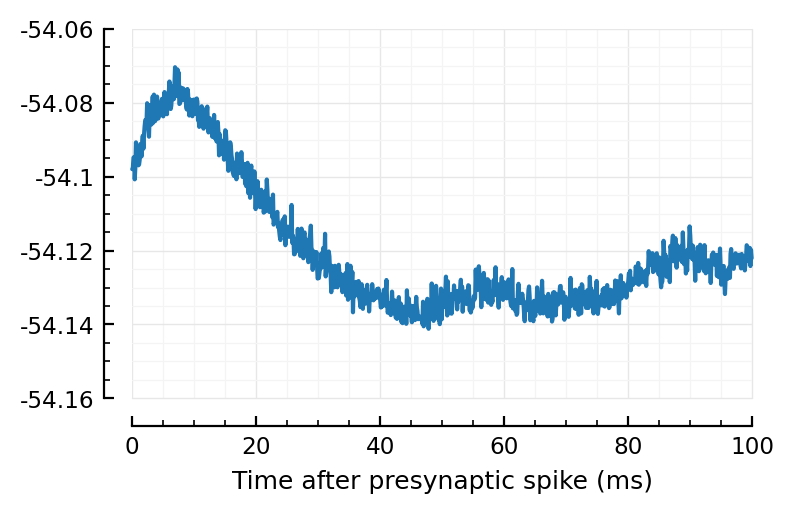

In [25]:
plotSTA_2(exc_inputs[1]);

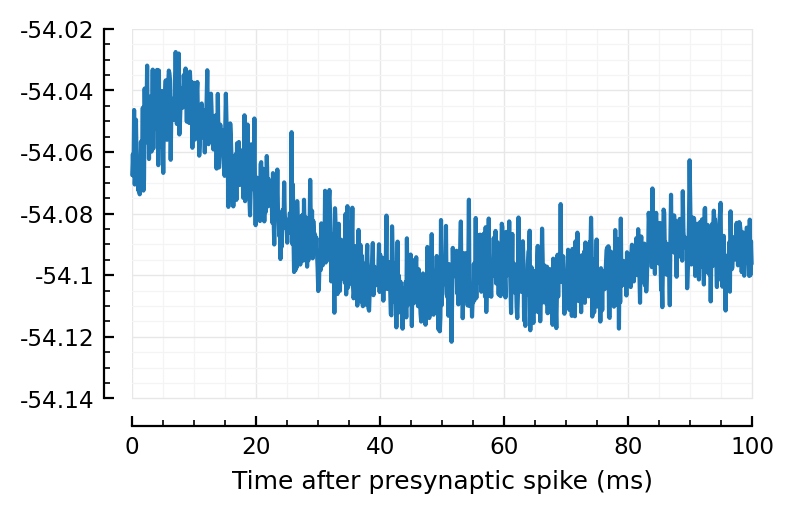

In [26]:
plotSTA_2(exc_inputs[1], sim_ceil);

Wow much worse, with ceiled spikes.

So, obviously, let's try and trim the spikes.\
Also, what's voltage histogram ey.

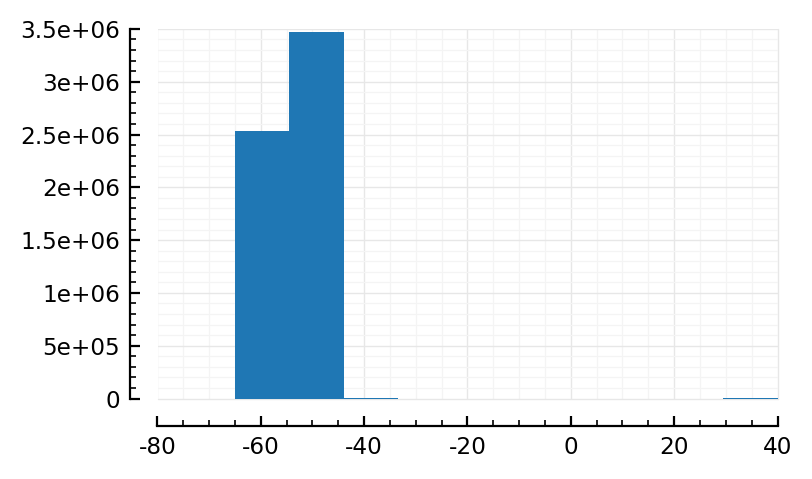

In [27]:
hist(sim_ceil.V / mV);

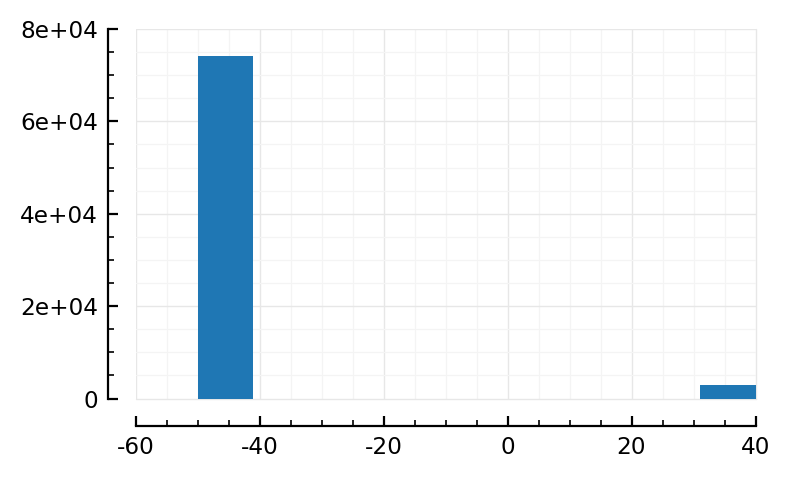

In [28]:
V = sim_ceil.V
hist(V[V .≥ -50mV] / mV);

Can we do automatic selection? percentiles let's see. Or outlier detection, or sth.

In [29]:
using Statistics

In [30]:
ps = [0, 0.01, 0.5, 0.9, 0.99, 0.999, 1]  # i.e. 0, 1, 50, 90, 99, 99.1, 100-percentiles.
qs = quantile(V, ps) / mV
DataFrame("Proportion"=>ps, "Value (mV)"=>round.(qs, digits=1))

Row,Proportion,Value (mV)
,Float64,Float64
1,0.0,-65.0
2,0.01,-58.1
3,0.5,-54.0
4,0.9,-51.6
5,0.99,-49.8
6,0.999,-46.8
7,1.0,40.0


In [31]:
V_clip = copy(sim_ceil.V)
V_clip[V_clip .≥ -50mV] .= -50mV;

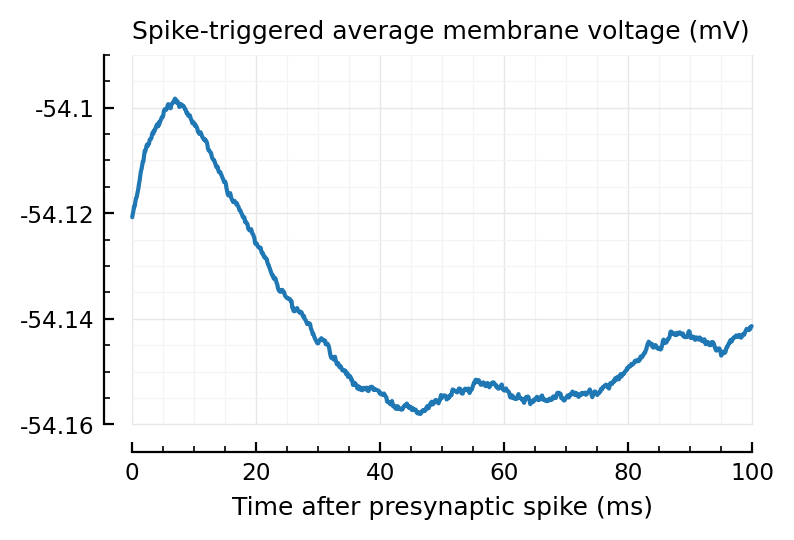

In [32]:
plotSTA(calc_STA(V_clip, exc_inputs[1].times));

Holy damn :OOOO  
This is so clean :OOOO.

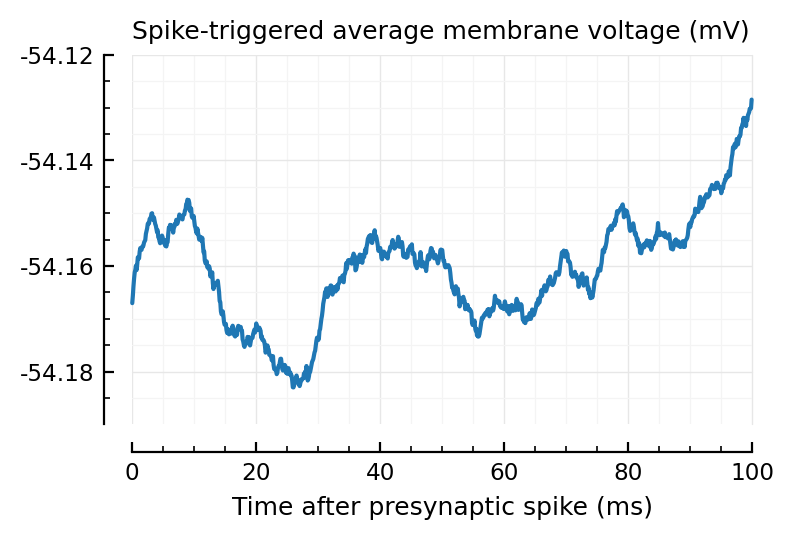

In [33]:
plotSTA(calc_STA(V_clip, exc_inputs[100].times));

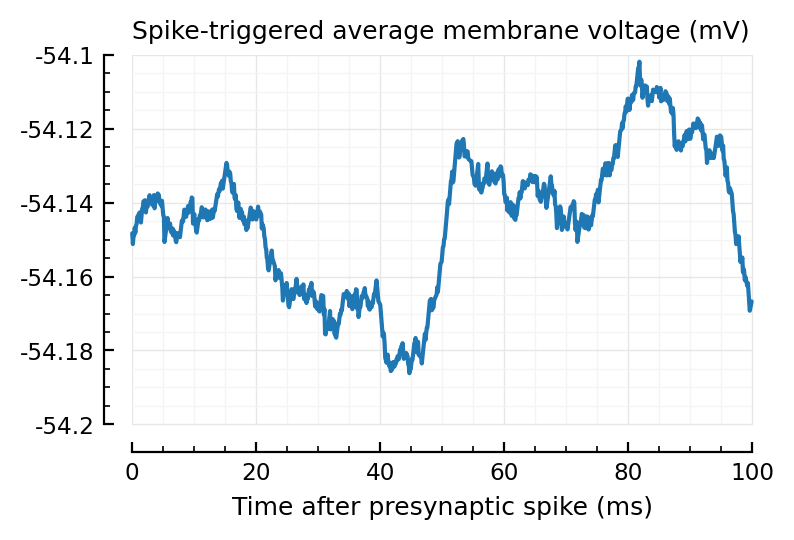

In [34]:
plotSTA(calc_STA(V_clip, exc_inputs[mid].times));

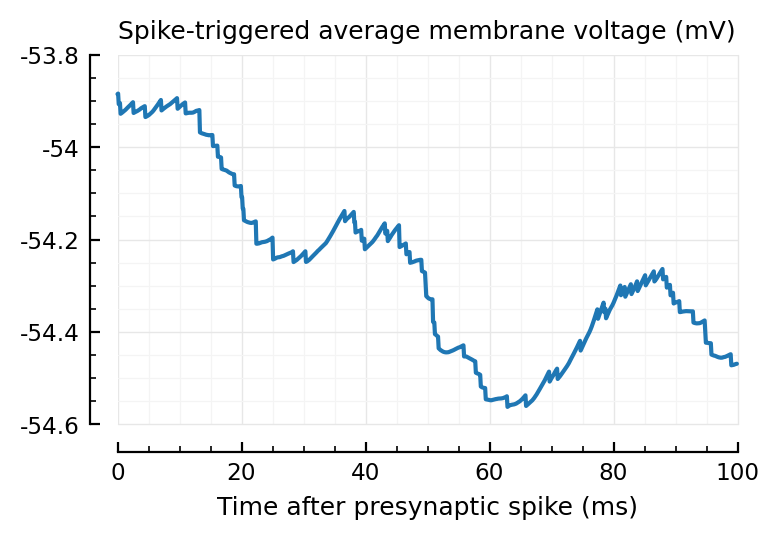

In [35]:
plotSTA(calc_STA(V_clip, exc_inputs[end].times));

Ok no real help for the lower spikers heh.

### Sig itself

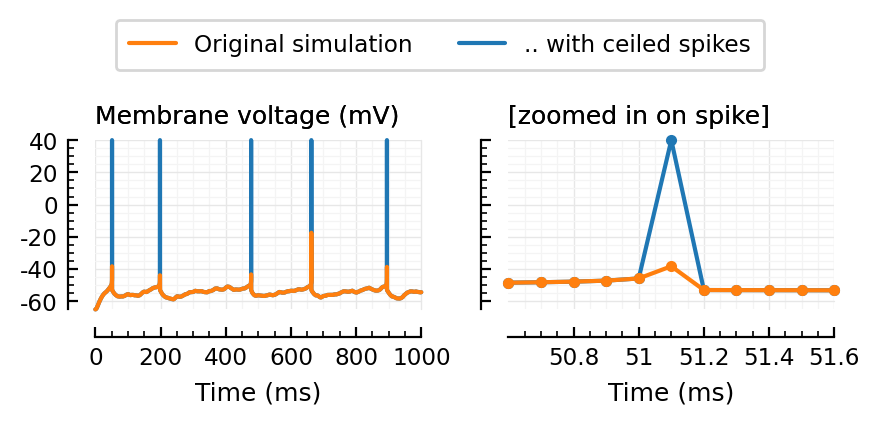

In [110]:
function ceilplot(; tlim, marker=nothing, ax, kw...)
    plotsig(sim_ceil.V / mV, tlim, ms, label=".. with ceiled spikes"; ax, marker, kw...);
    plotsig(sim.V / mV, tlim, ms, label="Original simulation"; ax, marker, kw...);
    # legend(ax, reorder=[1=>2]);
end

fig, axs = plt.subplots(ncols=2, figsize=(mtw, 0.4*mtw), sharey=true)
ceilplot(tlim = [0, 1000], ax=axs[0], hylabel="Membrane voltage (mV)");
ceilplot(tlim = [50.6, 51.6], marker=".", ax=axs[1], hylabel="[zoomed in on spike]");
l = axs[0].get_lines()
# rm_ticks_and_spine(axs[1], "left")
plt.figlegend(handles=[l[1], l[0]], ncols=2, loc="lower center", bbox_to_anchor=(0.5, 1))
plt.tight_layout();

## 'What would V would be w/o thresholding'

In [47]:
@time sim_r = Nto1AdEx.sim(N, duration, record_all=true);

  2.686393 seconds (6.03 M allocations: 1.383 GiB, 25.27% gc time)


We need to calc V.
Which is Vprev + Δt * ΔV

In [53]:
t = sim_r.spiketimes[1]
t / ms

51.200000000000436

In [89]:
(; Δt, Eₑ, Eᵢ, Δₜ, Vₜ, gₗ, Eₗ, C) = Nto1AdEx

i = round(Int, t/Δt)  # The spiketime `t` is one sample after where we want, but this i is correct

512

In [83]:
n = sim_r.recording[i];

In [95]:
(; V, gₑ, gᵢ, w) = n
V / mV

-38.24759825475466

In [99]:
n.DₜV

75.60870254277917

In [100]:
DₜV

966640.2938251279

In [97]:
Iₛ = gₑ*(V - Eₑ) + gᵢ*(V - Eᵢ)
DₜV  = (-gₗ*(V - Eₗ) + gₗ*Δₜ*exp((V-Vₜ)/Δₜ) - Iₛ - w) / C

V_new = V + Δt * DₜV
V_new / mV

96625.78178425804

Heh.